In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
import nltk
import spacy

In [48]:
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MiniBatchKMeans

In [49]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Prangon_Chakraborty\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package punkt is already up-to-date!


True

In [50]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Prangon_Chakraborty\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package wordnet is already up-to-date!


True

In [51]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Prangon_Chakraborty\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
data= pd.read_csv("./preprocessed_data.csv")

In [53]:
# data['PROCESSED_NARATION'] = data['STOP_WORD_REMOVED_NARATION'].str.replace('[^\w\s]', '', regex=True)

In [54]:
nlp = spacy.load('en_core_web_sm')
narations = data['STOP_WORD_REMOVED_NARATION'].dropna().unique()

In [55]:
# def str_to_list(words):
#     return words.split(' ')

# narations_modified = narations.apply(str_to_list)

In [56]:
data.head(5)

,Unnamed: 0.1,Unnamed: 0,AC_ID,AMOUNT,DOC_DATE,NARATION,DR_CR,STOP_WORD_REMOVED_NARATION
0,0,0,3644877,342800.0,01-NOV-22,"['cash', 'withdraw']",Debit,"['cash', 'withdraw']"
1,1,1,1175256,342800.0,01-NOV-22,"['cash', 'withdraw', 'from', 'a', 'c', 'no']",Credit,"['cash', 'withdraw']"
2,2,2,2298226,1500.0,01-NOV-22,"['cash', 'withdraw', 'from', 'micro', 'merchan...",Debit,"['cash', 'withdraw', 'micro', 'merchant', 'poi..."
3,3,3,4066427,1500.0,01-NOV-22,"['credit', 'against', 'merchant', 'cash', 'wit...",Credit,"['credit', 'merchant', 'cash', 'withdraw', 'se..."
4,4,4,1978564,2550.0,01-NOV-22,"['cash', 'withdraw', 'from', 'micro', 'merchan...",Debit,"['cash', 'withdraw', 'micro', 'merchant', 'poi..."


In [57]:
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(smooth_idf=True, use_idf=True, min_df = 5)
vectorizer.fit_transform(narations)

# using get_feature_names_out instead of get_feature_names
feature_names = vectorizer.get_feature_names_out()

In [58]:
def extract_n_from_top_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature, score
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

def sort_coo_matrix(coo_matrix):
    """----This function sorts a dict with highest score----"""
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def keywords(vectorizer, feature_names, doc, k=10):
    """--This method returns top k keywords from a doc using TF-IDF method--"""

    #generate tf-idf for the given document
    tf_idf_vector = vectorizer.transform([doc])
    
    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo_matrix(tf_idf_vector.tocoo())

    #extract only TOP_K_KEYWORDS
    keywords=extract_n_from_top_from_vector(feature_names,sorted_items,k)
    
    return list(keywords.keys())

In [59]:
TOP_K_KEYWORDS = 10
result = []
for sentence in narations:
    dataframe = {}
    dataframe['PROCESSED_NARATION_FINAL'] = sentence
    dataframe['TOP_KEYWORDS'] = keywords(vectorizer, feature_names, sentence, TOP_K_KEYWORDS)
    result.append(dataframe)
final_data = pd.DataFrame(result)

In [60]:
from gensim.models import Word2Vec
final_data['TOP_KEYWORDS'] = final_data['PROCESSED_NARATION_FINAL']
model = Word2Vec(final_data['TOP_KEYWORDS'], min_count=1, vector_size = 150)

In [83]:
def word2vec_mean_calc(text, model, vector_size=150):
    summ = np.zeros(vector_size)
    cnt = 1
    for word in text:
        summ+=model.wv[word]
        cnt+=1
    return summ/cnt

In [84]:
final_data['AVG_VECT'] = final_data['TOP_KEYWORDS'].apply(lambda text : word2vec_mean_calc(text,model))

In [85]:
# kmeans clustering
wcss = []
for i in range(7,15):
    kmeans = KMeans(i, init = 'k-means++', max_iter = 500,n_init = 10, random_state = 0)
    kmeans.fit(list(final_data['AVG_VECT']))
    wcss.append(kmeans.inertia_)

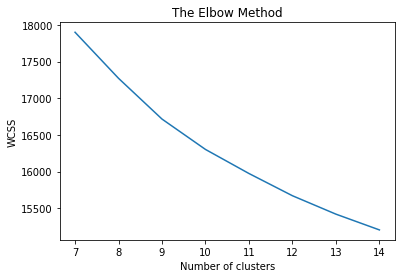

In [86]:
# plotting graph

plt.plot(range(7,15), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [87]:
# We got best value 15, now applying 15

kmeans = KMeans(n_clusters = 15, init = 'k-means++', max_iter = 500, n_init=10, random_state=0)

In [88]:
final_data['KMEANS_CLUSTER'] = kmeans.fit_predict(list(final_data['AVG_VECT']))

In [89]:
# determining value of eps for dbscan
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(list(final_data['AVG_VECT']))
distances, indices = neighbors_fit.kneighbors(list(final_data['AVG_VECT']))
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

MemoryError: Unable to allocate 1.00 GiB for an array with shape (1436, 93449) and data type float64

In [90]:
db = DBSCAN(eps=0.9, min_samples=300).fit(list(final_data['AVG_VECT']))
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

MemoryError: Unable to allocate 1.00 GiB for an array with shape (1436, 93449) and data type float64

In [91]:
final_data['DBSCAN_CLUSTER']  = labels

NameError: name 'labels' is not defined

In [92]:
kmeans = MiniBatchKMeans(n_clusters=12, random_state=0, batch_size=100)

In [93]:
final_data["MINIBATCH_CLUSTER"] = kmeans.fit_predict(list(final_data['AVG_VECT']))

AttributeError: 'NoneType' object has no attribute 'split'

In [94]:
# storing the final data to excel sheet
final_data.to_excel('final_result.xlsx')